In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Загрузка данных из файла
data_train = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date')

In [2]:
data_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col='date')

In [3]:
df = pd.merge(data_train, data_test, how='outer', on=['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'])

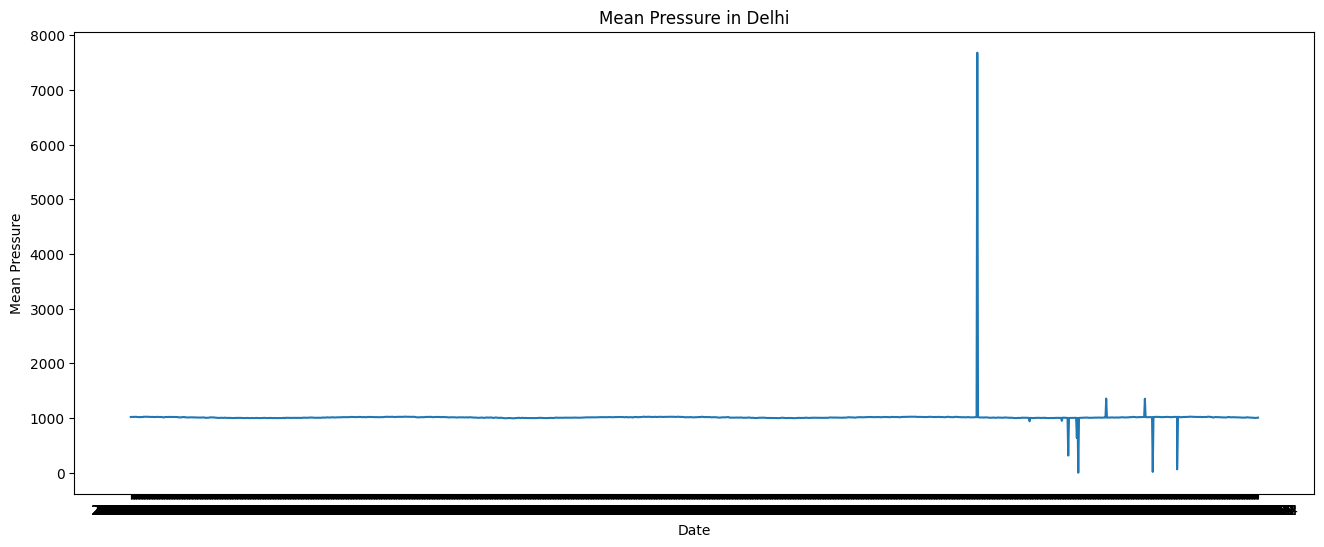

In [4]:
# Draw graph for meanpressure

plt.figure(figsize=(16, 6))
plt.plot(df.index, df['meanpressure'])
plt.title('Mean Pressure in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Pressure')
plt.show()

In [5]:
# Remove obvious outliers
df_filtered = df[(df['meanpressure'] >= 950) & (df['meanpressure'] <= 1200)]

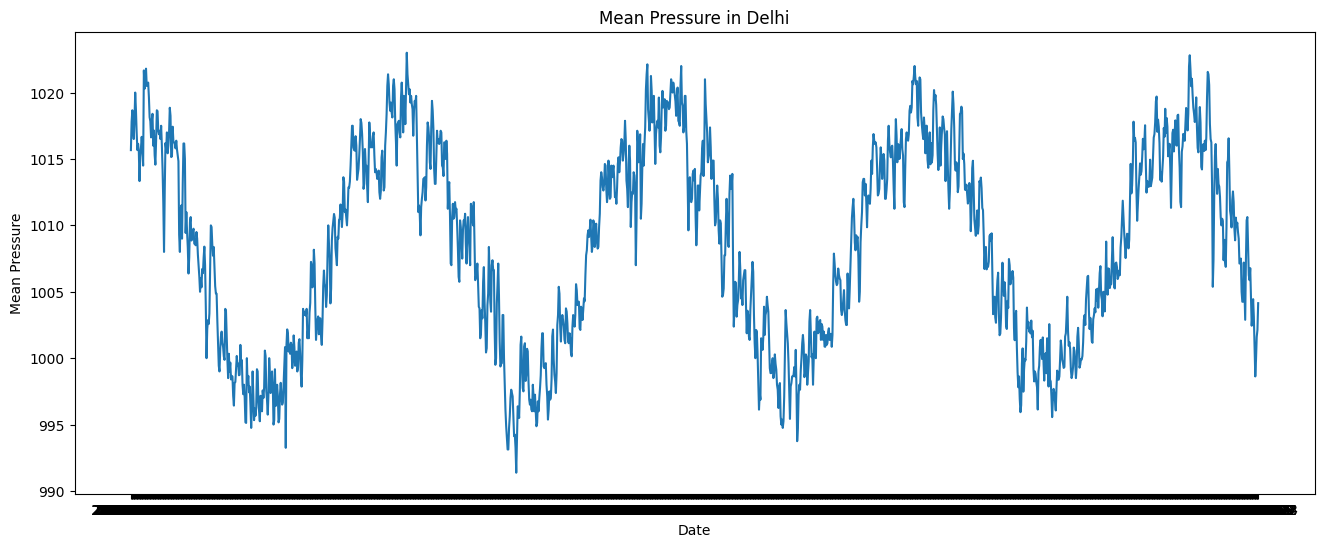

In [6]:
# Draw graph for meanpressure

plt.figure(figsize=(16, 6))
plt.plot(df_filtered.index, df_filtered['meanpressure'])
plt.title('Mean Pressure in Delhi')
plt.xlabel('Date')
plt.ylabel('Mean Pressure')
plt.show()

In [7]:
df_filtered

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [8]:
# Feature columns
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [9]:
# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [10]:
# Convert scaled data to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [11]:
scaled_df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,0.122271,0.820957,0.000000,0.132603
2013-01-02,0.042795,0.907591,0.070583,0.132881
2013-01-03,0.035662,0.849835,0.109743,0.132994
2013-01-04,0.081514,0.668867,0.029212,0.132799
2013-01-05,0.000000,0.847910,0.087636,0.132712
...,...,...,...,...
2017-04-20,0.871179,0.162541,0.131750,0.130385
2017-04-21,0.863537,0.299711,0.164910,0.130548
2017-04-22,0.822271,0.317327,0.210564,0.130772


In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [13]:
window_size = 10

# Create sequences
X, y = create_sequences(scaled_df.values, window_size)

In [14]:
len(X), len(y)

(1566, 1566)

In [15]:
# Split the sequences
X_train = X[:-113]
X_test = X[-113:]
y_train = y[:-113]
y_test = y[-113:]

In [16]:
from tensorflow.keras.callbacks import Callback

class PrintEvery10thEpoch(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:  # +1 because epoch indexing starts at 0
            print(f"Epoch {epoch + 1}, Loss: {logs['loss']}, Val Loss: {logs.get('val_loss')}")

# LSTM Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.007757413201034069, Val Loss: 0.008226623758673668
Epoch 20, Loss: 0.007051500026136637, Val Loss: 0.008222918026149273
Epoch 30, Loss: 0.006365559063851833, Val Loss: 0.0065454416908323765
Epoch 40, Loss: 0.005813179537653923, Val Loss: 0.005746088456362486
Epoch 50, Loss: 0.00564120477065444, Val Loss: 0.00578220235183835
Epoch 60, Loss: 0.005636497400701046, Val Loss: 0.005712263286113739
Epoch 70, Loss: 0.005359088070690632, Val Loss: 0.005539862904697657
Epoch 80, Loss: 0.005414467770606279, Val Loss: 0.00560269970446825
Epoch 90, Loss: 0.005413446109741926, Val Loss: 0.005399870220571756
Epoch 100, Loss: 0.005154154729098082, Val Loss: 0.005830375012010336


In [18]:
# Make predictions on the test set
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


In [19]:
len(predictions), len(y_test)

(113, 113)

In [20]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

In [21]:
# Evaluate on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 
Test Loss: 0.004410231485962868


In [22]:
predictions_inverse

array([[  15.718604 ,   80.21362  ,    7.1213107,  989.7072   ],
       [  17.379015 ,   75.59729  ,    8.209573 ,  957.35205  ],
       [  17.261118 ,   79.05865  ,    7.4982467,  950.05444  ],
       [  18.534822 ,   71.57258  ,    8.57959  ,  962.6088   ],
       [  18.527967 ,   72.92809  ,    7.521598 ,  971.9435   ],
       [  19.106806 ,   72.926346 ,    7.8729806,  977.5308   ],
       [  17.167294 ,   81.91616  ,    6.036431 ,  990.3247   ],
       [  17.380428 ,   75.63862  ,    6.4766316, 1002.2996   ],
       [  16.655815 ,   74.71776  ,    6.2808576, 1002.9494   ],
       [  15.603938 ,   70.769806 ,    6.561572 , 1023.9346   ],
       [  14.095744 ,   70.97178  ,    6.280111 , 1054.3307   ],
       [  13.39827  ,   72.042015 ,    6.1669307, 1055.7007   ],
       [  14.021852 ,   68.25597  ,    7.277043 , 1041.2845   ],
       [  14.059557 ,   71.340294 ,    6.7370872, 1029.6149   ],
       [  15.619404 ,   70.02709  ,    7.720432 , 1013.4029   ],
       [  15.553052 ,   7

In [23]:
y_test_inverse

array([[  18.5       ,   77.22222222,    2.89444444, 1018.27777778],
       [  17.11111111,   81.88888889,    4.01666667, 1018.33333333],
       [  18.7       ,   70.05      ,    4.545     , 1015.7       ],
       [  18.38888889,   74.94444444,    3.3       , 1014.33333333],
       [  19.31818182,   79.31818182,    8.68181818, 1011.77272727],
       [  14.70833333,   95.83333333,   10.04166667, 1011.375     ],
       [  15.68421053,   83.52631579,    1.95      , 1015.55      ],
       [  14.57142857,   80.80952381,    6.54285714, 1015.95238095],
       [  12.11111111,   71.94444444,    9.36111111, 1016.88888889],
       [  11.        ,   72.11111111,    9.77222222, 1016.77777778],
       [  11.78947368,   74.57894737,    6.62631579, 1016.36842105],
       [  13.23529412,   67.05882353,    6.43529412, 1017.52941176],
       [  13.2       ,   74.28      ,    5.276     , 1018.84      ],
       [  16.43478261,   72.56521739,    3.63043478, 1018.13043478],
       [  14.65      ,   78.45    

In [24]:
evaluation_map = {}

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

evaluation_map['LSTM'] = {}
evaluation_map['LSTM']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['LSTM']['MAE'] = mean_absolute_error(y_test, predictions)

In [26]:
print(evaluation_map)

{'LSTM': {'MSE': 0.004410231411752505, 'MAE': 0.045973305696767025}}


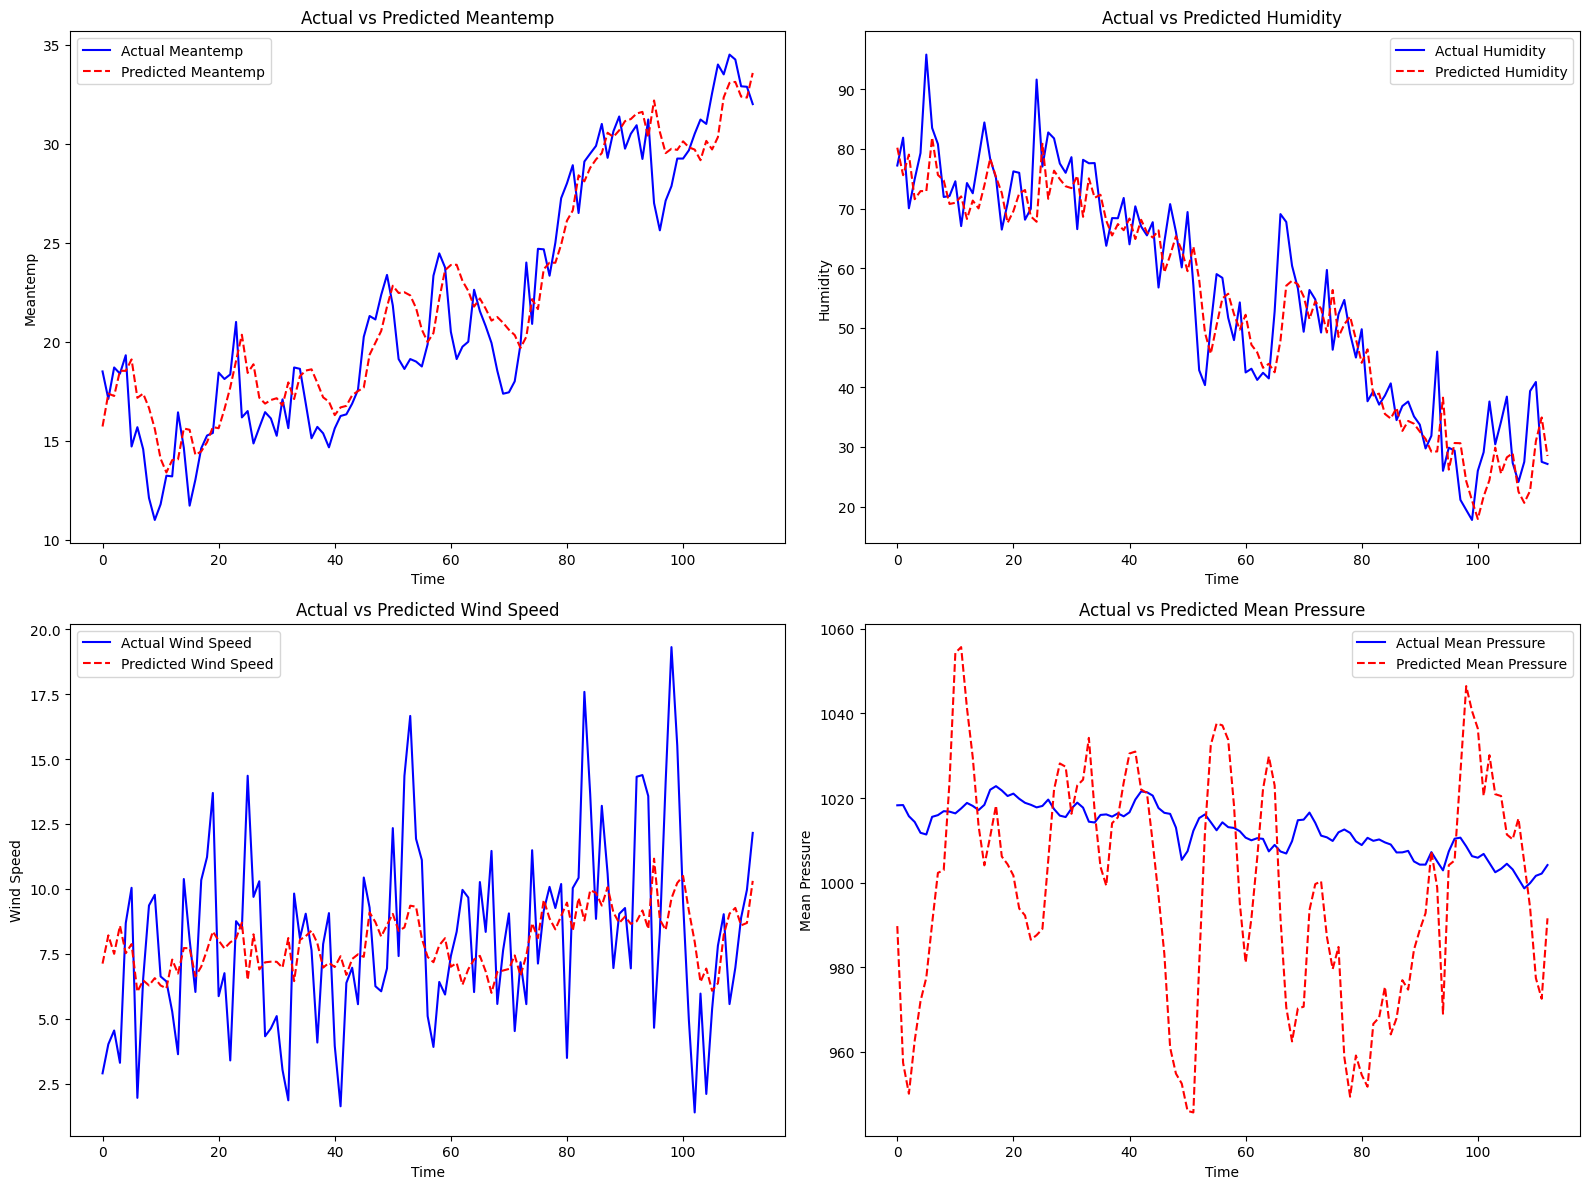

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume predictions_inverse and y_test_inverse are available and shaped correctly
# Split the predictions and actual values by feature
predictions_meantemp = predictions_inverse[:, 0]
predictions_humidity = predictions_inverse[:, 1]
predictions_wind_speed = predictions_inverse[:, 2]
predictions_meanpressure = predictions_inverse[:, 3]

y_test_meantemp = y_test_inverse[:, 0]
y_test_humidity = y_test_inverse[:, 1]
y_test_wind_speed = y_test_inverse[:, 2]
y_test_meanpressure = y_test_inverse[:, 3]

# Create DataFrames for each feature
plot_df_meantemp = pd.DataFrame({
    'Actual': y_test_meantemp,
    'Predicted': predictions_meantemp
}, index=pd.RangeIndex(start=0, stop=len(y_test_meantemp), step=1))

plot_df_humidity = pd.DataFrame({
    'Actual': y_test_humidity,
    'Predicted': predictions_humidity
}, index=pd.RangeIndex(start=0, stop=len(y_test_humidity), step=1))

plot_df_wind_speed = pd.DataFrame({
    'Actual': y_test_wind_speed,
    'Predicted': predictions_wind_speed
}, index=pd.RangeIndex(start=0, stop=len(y_test_wind_speed), step=1))

plot_df_meanpressure = pd.DataFrame({
    'Actual': y_test_meanpressure,
    'Predicted': predictions_meanpressure
}, index=pd.RangeIndex(start=0, stop=len(y_test_meanpressure), step=1))

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# GRU Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.0063617043197155, Val Loss: 0.006449125241488218
Epoch 20, Loss: 0.005646824836730957, Val Loss: 0.005749278236180544
Epoch 30, Loss: 0.005258277524262667, Val Loss: 0.005303459707647562
Epoch 40, Loss: 0.005219645332545042, Val Loss: 0.0051938011310994625
Epoch 50, Loss: 0.005073120817542076, Val Loss: 0.005262305960059166
Epoch 60, Loss: 0.005158377345651388, Val Loss: 0.005060983821749687
Epoch 70, Loss: 0.005065512843430042, Val Loss: 0.005125630181282759
Epoch 80, Loss: 0.005027678795158863, Val Loss: 0.005041792057454586
Epoch 90, Loss: 0.00508743105456233, Val Loss: 0.005116958636790514
Epoch 100, Loss: 0.0049592358991503716, Val Loss: 0.0049928175285458565


In [29]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [30]:
evaluation_map['GRU'] = {}
evaluation_map['GRU']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['GRU']['MAE'] = mean_absolute_error(y_test, predictions)

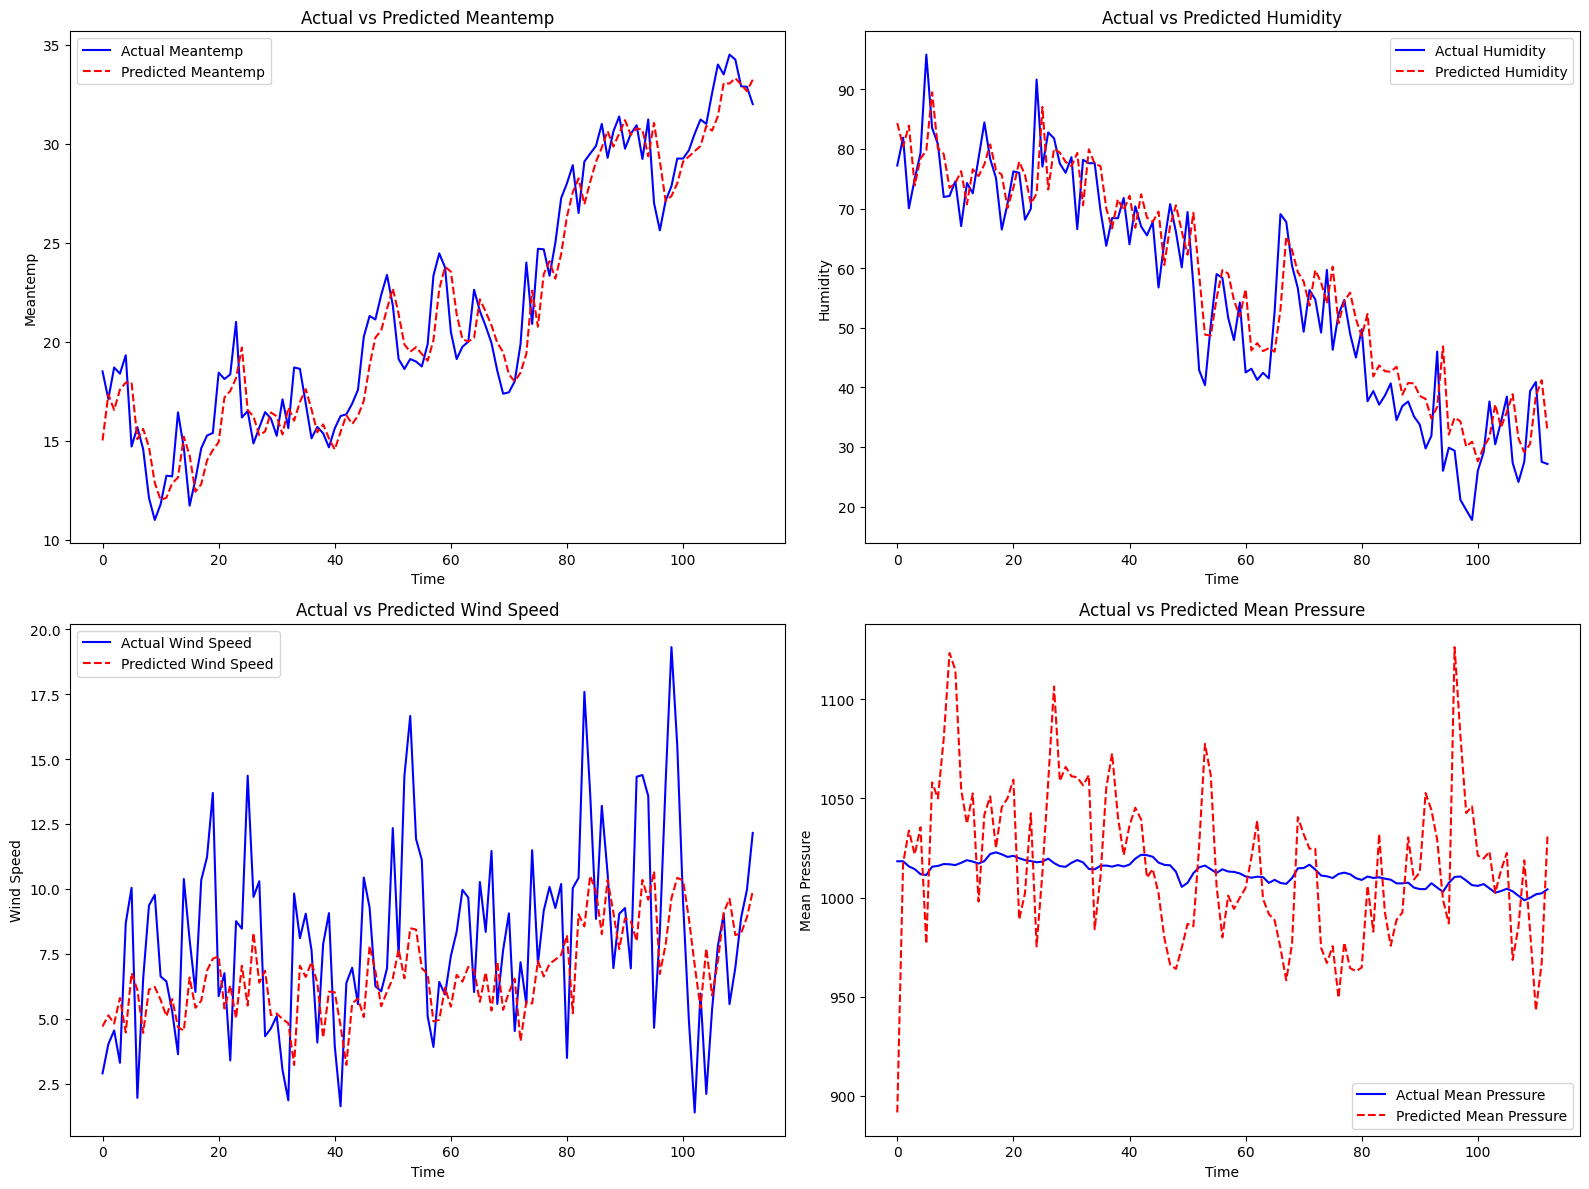

In [31]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Create DataFrames for plotting each feature
def create_plot_df(predictions, actuals):
    return pd.DataFrame({
        'Actual': actuals.flatten(),
        'Predicted': predictions.flatten()
    })

plot_df_meantemp = create_plot_df(predictions_inverse[:, 0], y_test_inverse[:, 0])
plot_df_humidity = create_plot_df(predictions_inverse[:, 1], y_test_inverse[:, 1])
plot_df_wind_speed = create_plot_df(predictions_inverse[:, 2], y_test_inverse[:, 2])
plot_df_meanpressure = create_plot_df(predictions_inverse[:, 3], y_test_inverse[:, 3])

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# RNN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(SimpleRNN(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.005830204114317894, Val Loss: 0.005920870695263147
Epoch 20, Loss: 0.005188839975744486, Val Loss: 0.0060800909996032715
Epoch 30, Loss: 0.005011301022022963, Val Loss: 0.005481812171638012
Epoch 40, Loss: 0.004801403731107712, Val Loss: 0.005495138466358185
Epoch 50, Loss: 0.0047386023215949535, Val Loss: 0.005702970549464226
Epoch 60, Loss: 0.004629465285688639, Val Loss: 0.005703514441847801
Epoch 70, Loss: 0.004466549027711153, Val Loss: 0.0057118856348097324
Epoch 80, Loss: 0.004337032791227102, Val Loss: 0.00591780710965395
Epoch 90, Loss: 0.004304094705730677, Val Loss: 0.005804039537906647
Epoch 100, Loss: 0.0038921115919947624, Val Loss: 0.006026853807270527


In [33]:
# Make predictions
predictions = model.predict(X_test)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002D47209ADE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [34]:
evaluation_map['RNN'] = {}
evaluation_map['RNN']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['RNN']['MAE'] = mean_absolute_error(y_test, predictions)

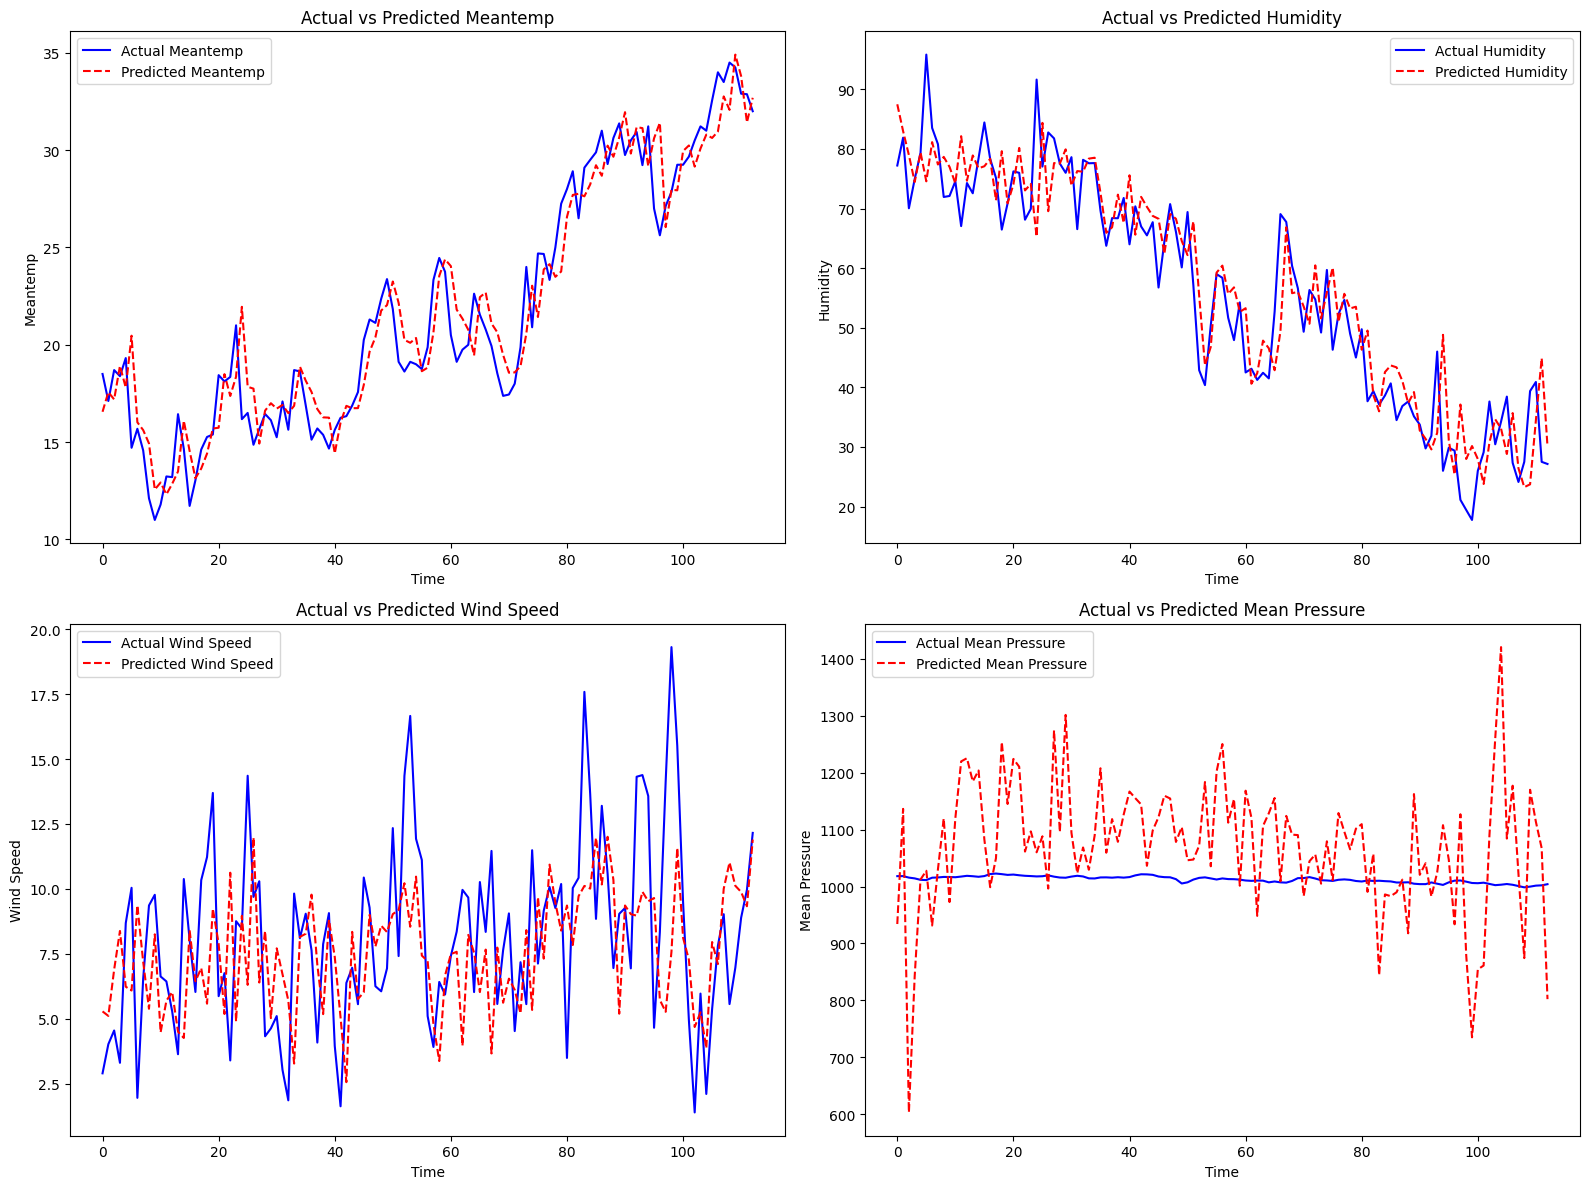

In [35]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Create DataFrames for plotting each feature
def create_plot_df(predictions, actuals):
    return pd.DataFrame({
        'Actual': actuals.flatten(),
        'Predicted': predictions.flatten()
    })

plot_df_meantemp = create_plot_df(predictions_inverse[:, 0], y_test_inverse[:, 0])
plot_df_humidity = create_plot_df(predictions_inverse[:, 1], y_test_inverse[:, 1])
plot_df_wind_speed = create_plot_df(predictions_inverse[:, 2], y_test_inverse[:, 2])
plot_df_meanpressure = create_plot_df(predictions_inverse[:, 3], y_test_inverse[:, 3])

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Attention Mechanism with LSTM

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionMechanism(Layer):
    def __init__(self, return_sequences=True):
        super(AttentionMechanism, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x,self.W)+self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(AttentionMechanism(return_sequences=True))  # Внимание после LSTM
model.add(LSTM(32, return_sequences=False))
model.add(Dense(4))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 10, Loss: 0.008709782734513283, Val Loss: 0.009006578475236893
Epoch 20, Loss: 0.007622108794748783, Val Loss: 0.007781225256621838
Epoch 30, Loss: 0.007141843903809786, Val Loss: 0.007441781461238861
Epoch 40, Loss: 0.00688168965280056, Val Loss: 0.007312246132642031
Epoch 50, Loss: 0.006392755080014467, Val Loss: 0.006450519897043705
Epoch 60, Loss: 0.006442868150770664, Val Loss: 0.005893168039619923
Epoch 70, Loss: 0.005874973256140947, Val Loss: 0.006128780543804169
Epoch 80, Loss: 0.005717264488339424, Val Loss: 0.005979674868285656
Epoch 90, Loss: 0.005558704026043415, Val Loss: 0.005312885623425245
Epoch 100, Loss: 0.005505039356648922, Val Loss: 0.005297679454088211


In [38]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [39]:
evaluation_map['LSTM with Attention'] = {}
evaluation_map['LSTM with Attention']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['LSTM with Attention']['MAE'] = mean_absolute_error(y_test, predictions)

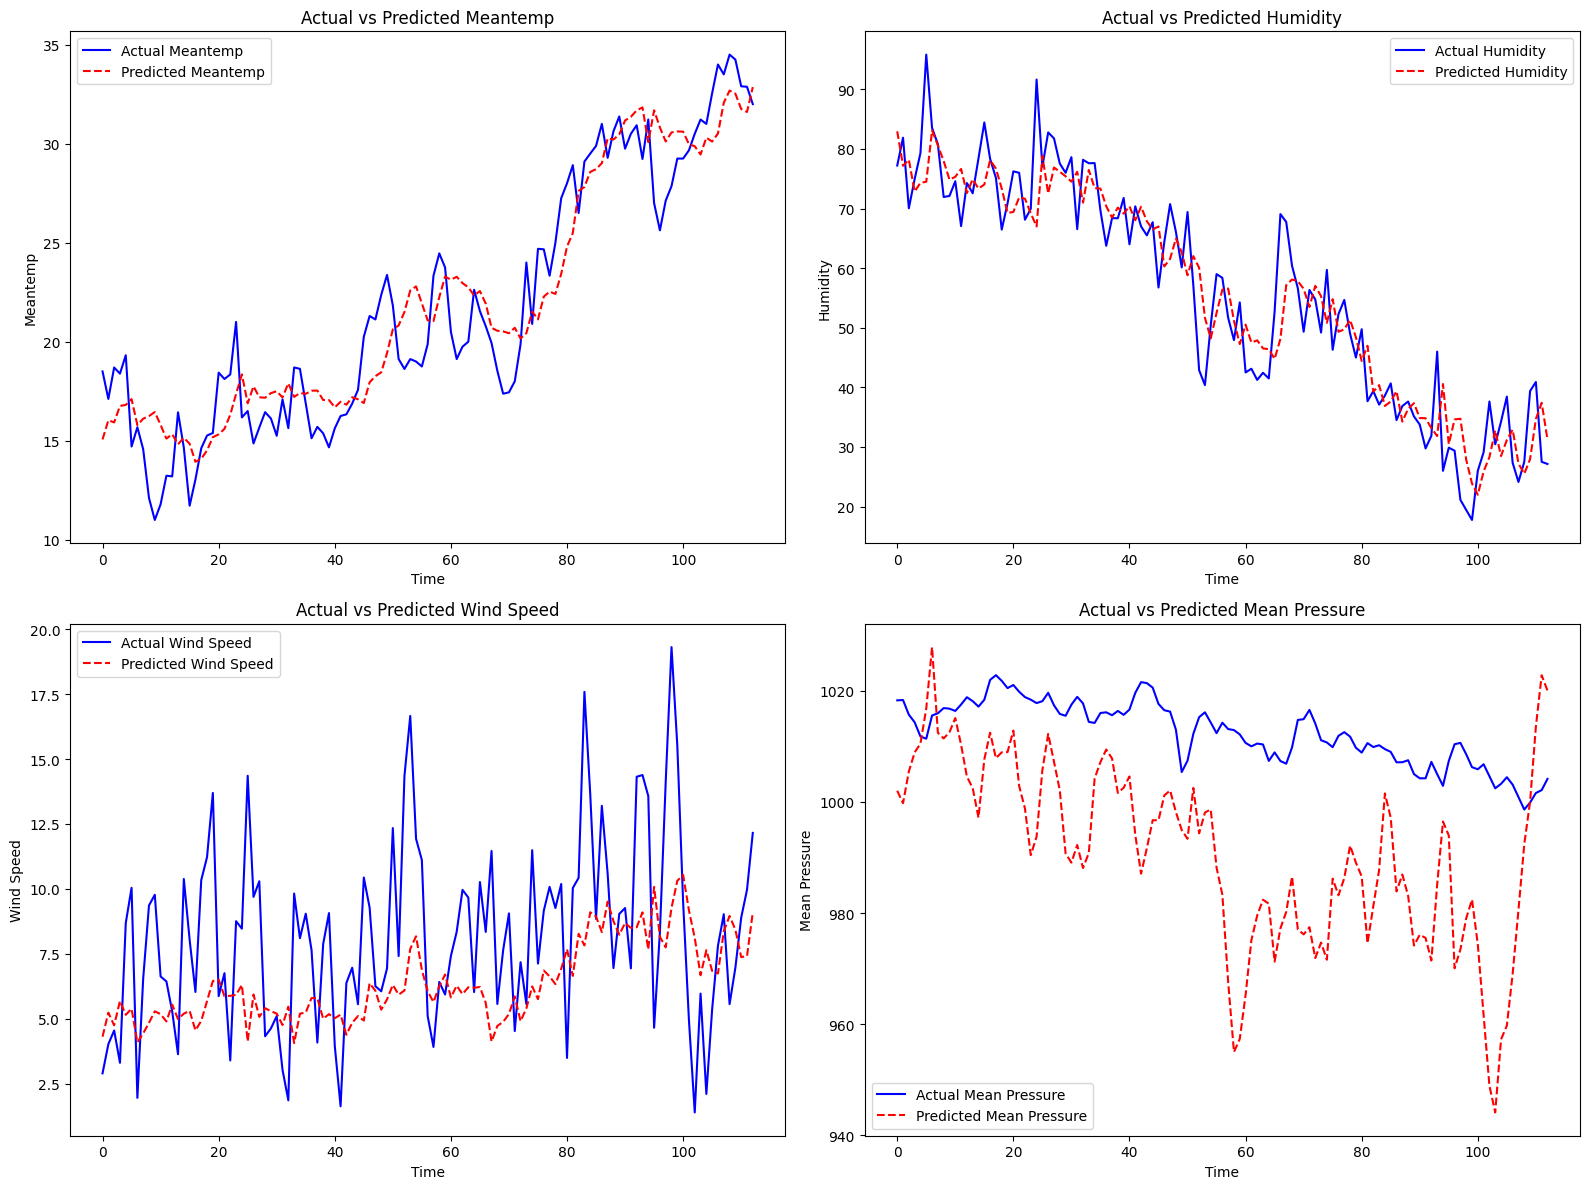

In [40]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Create DataFrames for plotting each feature
def create_plot_df(predictions, actuals):
    return pd.DataFrame({
        'Actual': actuals.flatten(),
        'Predicted': predictions.flatten()
    })

plot_df_meantemp = create_plot_df(predictions_inverse[:, 0], y_test_inverse[:, 0])
plot_df_humidity = create_plot_df(predictions_inverse[:, 1], y_test_inverse[:, 1])
plot_df_wind_speed = create_plot_df(predictions_inverse[:, 2], y_test_inverse[:, 2])
plot_df_meanpressure = create_plot_df(predictions_inverse[:, 3], y_test_inverse[:, 3])

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# GRU with Attention

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(AttentionMechanism(return_sequences=True))  # Attention after GRU
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.00827738456428051, Val Loss: 0.008955057710409164
Epoch 20, Loss: 0.00699917646124959, Val Loss: 0.007499621249735355
Epoch 30, Loss: 0.006705604959279299, Val Loss: 0.00694109546020627
Epoch 40, Loss: 0.006268779747188091, Val Loss: 0.0063305022194981575
Epoch 50, Loss: 0.006055660545825958, Val Loss: 0.005966750904917717
Epoch 60, Loss: 0.005679803900420666, Val Loss: 0.005806234665215015
Epoch 70, Loss: 0.005564750637859106, Val Loss: 0.005567335058003664
Epoch 80, Loss: 0.005434753838926554, Val Loss: 0.005631435662508011
Epoch 90, Loss: 0.00540913175791502, Val Loss: 0.005387847777456045
Epoch 100, Loss: 0.005462882574647665, Val Loss: 0.0052652424201369286


In [42]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


In [43]:
evaluation_map['GRU with Attention'] = {}
evaluation_map['GRU with Attention']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['GRU with Attention']['MAE'] = mean_absolute_error(y_test, predictions)

# RNN with Attention

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(AttentionMechanism(return_sequences=True))  # Attention after RNN
model.add(SimpleRNN(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.007580839097499847, Val Loss: 0.007971315644681454
Epoch 20, Loss: 0.0064003621228039265, Val Loss: 0.006438831798732281
Epoch 30, Loss: 0.006128620356321335, Val Loss: 0.006393081974238157
Epoch 40, Loss: 0.005547661334276199, Val Loss: 0.005508071277290583
Epoch 50, Loss: 0.0054139988496899605, Val Loss: 0.005354069638997316
Epoch 60, Loss: 0.005178095772862434, Val Loss: 0.0052772159688174725
Epoch 70, Loss: 0.005057035945355892, Val Loss: 0.005182273685932159
Epoch 80, Loss: 0.004869532305747271, Val Loss: 0.005205190274864435
Epoch 90, Loss: 0.004718519747257233, Val Loss: 0.005932001397013664
Epoch 100, Loss: 0.004807502496987581, Val Loss: 0.0054100085981190205


In [45]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


In [46]:
evaluation_map['RNN with Attention'] = {}
evaluation_map['RNN with Attention']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['RNN with Attention']['MAE'] = mean_absolute_error(y_test, predictions)

In [47]:
evaluation_map

{'LSTM': {'MSE': 0.004410231411752505, 'MAE': 0.045973305696767025},
 'GRU': {'MSE': 0.004239657933734576, 'MAE': 0.04459857792507044},
 'RNN': {'MSE': 0.0046977114982291205, 'MAE': 0.047868528916415715},
 'LSTM with Attention': {'MSE': 0.0049057715765239325,
  'MAE': 0.0491745923511964},
 'GRU with Attention': {'MSE': 0.004262695641407938,
  'MAE': 0.04534679140210393},
 'RNN with Attention': {'MSE': 0.004422684098814071,
  'MAE': 0.046533621388800864}}

In [48]:
# Sort on MSE
evaluation_map_by_MSE = dict(sorted(evaluation_map.items(), key=lambda x: x[1]['MSE']))

print("Model                MSE")
# Print each model's results
for model, metrics in evaluation_map_by_MSE.items():
    mse = metrics['MSE']
    print(f"{model:<20} {mse:<20.10f}")

Model                MSE
GRU                  0.0042396579        
GRU with Attention   0.0042626956        
LSTM                 0.0044102314        
RNN with Attention   0.0044226841        
RNN                  0.0046977115        
LSTM with Attention  0.0049057716        


In [49]:
# Sort on MAE
evaluation_map_by_MAE = dict(sorted(evaluation_map.items(), key=lambda x: x[1]['MAE']))

print("Model                MAE")
# Print each model's results
for model, metrics in evaluation_map_by_MAE.items():
    mae = metrics['MAE']
    print(f"{model:<20} {mae:<20.10f}")

Model                MAE
GRU                  0.0445985779        
GRU with Attention   0.0453467914        
LSTM                 0.0459733057        
RNN with Attention   0.0465336214        
RNN                  0.0478685289        
LSTM with Attention  0.0491745924        
